In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import os
import matplotlib.pyplot as plt

In [2]:
# Population data and the census data, also extract the total and studied attributes
folder_loc = "data/synpop_related"
to_analyse_data = {
    # "SAA_hhsz_rm30": "SAA_HH_oriseed_IPL_abs_hhsz_first_no_penal_rm0_add_zero_cells.csv",
    # "SAA_hhsz_rm0": "SAA_HH_oriseed_IPL_abs_hhsz_first_no_penal_rm30_add_zero_cells.csv",
    # "SAA_hhsz_zerocellstill": "SAA_HH_oriseed_IPL_abs_hhsz_first_no_penal_rm30_missing_zero_cells.csv",
    "SAA_BN_pool": "SAA_HH_paper_BN_IPL_ordered_rm30_2.csv",
    "SAA_seed_addzero": "SAA_HH_paper_oriseed_IPL_ordered_rm30_addzero.csv",
    "SAA_seed_misszero": "SAA_HH_paper_oriseed_IPL_ordered_rm30_misszero.csv",
    "IPF_normal": "IPF_using_normals_seed.csv",
    "IPF_fromBN": "IPF_BN_pool2.csv",
    "WGAN_hhsz": "sampled_wgan_syn.csv",
    "BN_hhsz": "sampled_BN_syn.csv",
    "seed": "hh_sample_ipu.csv", # Main one always there
}
assert "seed" in to_analyse_data

In [3]:
color_code = {
    "SAA_BN_pool": "#1f77b4",
    "SAA_seed_addzero": "#ff7f0e",
    "SAA_seed_misszero": "#2ca02c",
    "IPF_normal": "#d62728",
    "IPF_fromBN": "#9467bd",
    "WGAN_hhsz": "#8c564b",
    "BN_hhsz": "#e377c2",
}

In [4]:
# Reading the file to df
processed_analyse_data = {name: pd.read_csv(os.path.join(folder_loc, file)) for name, file in to_analyse_data.items() if name != "seed"}

C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_25028\240776870.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  processed_analyse_data = {name: pd.read_csv(os.path.join(folder_loc, file)) for name, file in to_analyse_data.items() if name != "seed"}


In [5]:
seed = pd.read_csv(os.path.join(folder_loc, to_analyse_data["seed"]))

In [6]:
census = pd.read_csv(os.path.join(folder_loc, "hh_marginals_ipu.csv"), header=[0,1])

In [7]:
atts = set(census.columns.get_level_values(0)) - {"sample_geog", "zone_id"}
census.columns = census.columns.to_flat_index()

In [8]:
def get_jsd(sum_target: pd.Series, sum_truth:pd.Series):
    # if att == "hhinc" and "Negative income" in sum_df.index:
    #     sum_df = sum_df.drop(index="Negative income")
    p, q = sum_target.align(sum_truth, fill_value=0)

    # Convert to NumPy arrays
    p_array = p.to_numpy()
    q_array = q.to_numpy()

    # Compute Jensen-Shannon Distance
    js_distance = jensenshannon(p_array, q_array)
    return js_distance
    # print(f"Jensen-Shannon Distance for {att}: {js_distance}")


def wrapper_get_jsd_by_att(att: str, df: pd.DataFrame, seed: pd.DataFrame):
    sum_df = df[att].astype(str).value_counts(normalize=True)
    sum_seed = seed[att].astype(str).value_counts(normalize=True)
    return get_jsd(sum_df, sum_seed)

In [9]:
updated_results = {}
for name, df in processed_analyse_data.items():
    hold = {}
    for att in atts:
        hold[att] = wrapper_get_jsd_by_att(att, df, seed)
    updated_results[name] = pd.Series(hold)

In [10]:
# process census
census_hold = {}
for att in atts:
    sub_census = census[[x for x in census.columns if att == x[0]]]
    sum_census = sub_census.sum() / sub_census.sum().sum()
    sum_census.index = [x[1] for x in sum_census.index]

    sum_seed = seed[att].astype(str).value_counts(normalize=True)
    
    # Compute Jensen-Shannon Distance
    census_hold[att] = get_jsd(sum_census, sum_seed)
updated_results["census"] = pd.Series(census_hold)

In [11]:
last_order = ["hhsize", "totalvehs", "hhinc", "dwelltype", "owndwell"]
jsd_results = pd.DataFrame(updated_results).reindex(last_order)
jsd_results = jsd_results.drop(columns=["census"])
jsd_results

,SAA_BN_pool,SAA_seed_addzero,SAA_seed_misszero,IPF_normal,IPF_fromBN,WGAN_hhsz,BN_hhsz
hhsize,0.075489,0.075458,0.074765,0.069133,0.075346,0.075489,0.075489
totalvehs,0.043038,0.043108,0.042754,0.041844,0.043243,0.023141,0.013424
hhinc,0.187654,0.187553,0.180602,0.180920,0.187525,0.123193,0.083078
dwelltype,0.117351,0.117091,0.117044,0.117088,0.117315,0.065454,0.003152
owndwell,0.091831,0.091189,0.091235,0.089448,0.092411,0.018026,0.004210


<Axes: ylabel='JSD against seed'>

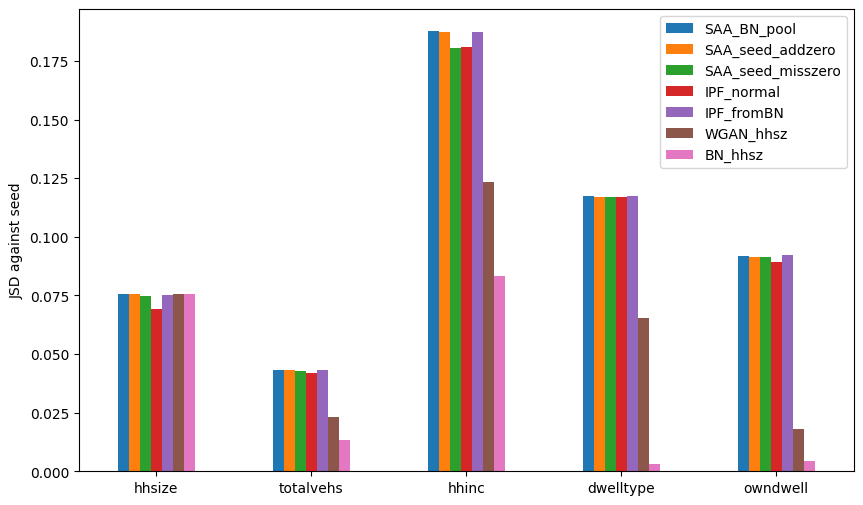

In [12]:
jsd_results.plot(kind='bar', figsize=(10, 6), rot=0, ylabel="JSD against seed",color=[color_code[x] for x in jsd_results.columns])

### Check special case of hhsize

In [13]:
check_att = "hhinc"
possible_states = [x[1] for x in census.columns if x[0] == check_att]

In [14]:
prob_hhsz = {name: df[check_att].astype("str").value_counts(normalize=True) for name, df in processed_analyse_data.items()}
prob_hhsz["seed"] = seed[check_att].astype("str").value_counts(normalize=True)

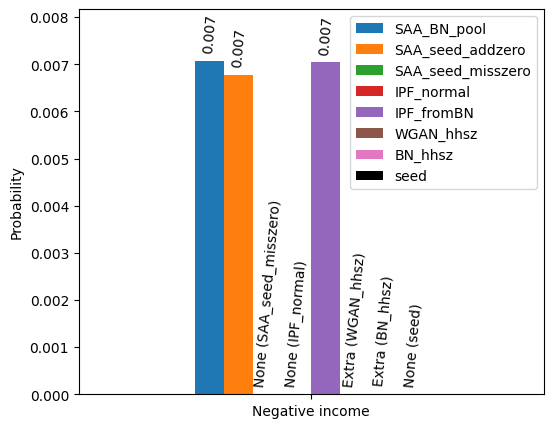

In [15]:
# Create the bar plot
temp_df = pd.DataFrame(prob_hhsz)
expected_colors = [color_code[x] for x in temp_df.columns if x != "seed"]
expected_colors.append("#000000")
ax = temp_df[temp_df.index=="Negative income"].plot(kind='bar', figsize=(6, 5), ylabel="Probability", xlabel="", color=expected_colors)

# Set x-axis labels to be horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")

# Adjust y-axis limits to create space for labels
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1.1)  # Increase upper limit by 10%

# Define a threshold for distinguishing "Nothing" (true zero) vs. "Extreme" (very small)
threshold = 1e-4  # Adjust this value based on your dataset

# Get column names from the DataFrame (these correspond to the legend labels)
column_labels = temp_df.columns.tolist()

# Add custom labels
for container, col_name in zip(ax.containers, column_labels):
    labels = []
    for val in container.datavalues:
        if val == 0:
            labels.append(f"None ({col_name})")  # True zero
        elif abs(val) < threshold:
            labels.append(f"Extra ({col_name})")  # Very small number
        else:
            labels.append(f"{val:.3f}")  # Normal number with 4 decimals
    ax.bar_label(container, labels=labels, padding=5, rotation=85)

# Show the plot
plt.show()

In [16]:
jsd_results.mean()

SAA_BN_pool          0.103073
SAA_seed_addzero     0.102880
SAA_seed_misszero    0.101280
IPF_normal           0.099687
IPF_fromBN           0.103168
WGAN_hhsz            0.061061
BN_hhsz              0.035870
dtype: float64

### case of comparing directly with the seed combinatin count

In [17]:
convert_all_to_comb_count = {name: df.reindex(columns=last_order).value_counts(normalize=True) for name, df in processed_analyse_data.items()}

In [18]:
seed_comb_all_count = seed.reindex(columns=last_order).value_counts(normalize=True)

In [19]:
pool = pd.read_csv(os.path.join(folder_loc, "HH_pool.csv"))
pool_comb_all_count = pool.reindex(columns=last_order).value_counts(normalize=True)

In [20]:
jsd_all_against_seed = {name: get_jsd(df, seed_comb_all_count) for name, df in convert_all_to_comb_count.items()}

C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_25028\554628760.py:4: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  p, q = sum_target.align(sum_truth, fill_value=0)


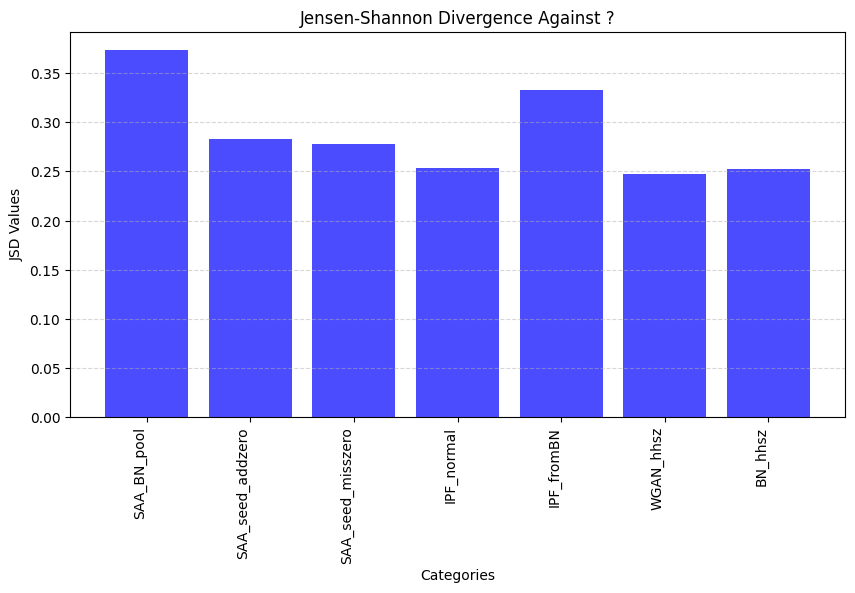

In [21]:
# Convert keys and values to lists for plotting
x_labels = list(jsd_all_against_seed.keys())
y_values = list(jsd_all_against_seed.values())

plt.figure(figsize=(10, 5))  # Set figure size
plt.bar(x_labels, y_values, color='blue', alpha=0.7)  # Customize color and transparency
plt.xticks(rotation=90, ha='right')  # Rotate x labels 90 degrees
plt.xlabel("Categories")  # Label x-axis
plt.ylabel("JSD Values")  # Label y-axis
plt.title("Jensen-Shannon Divergence Against ?")  # Add title
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid for better readability

plt.show()

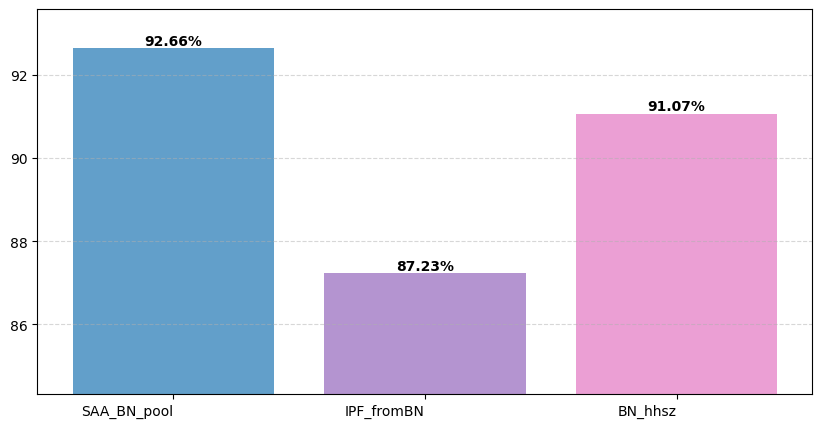

In [34]:
comb_count = {name: 100*len(df.index)/len(pool_comb_all_count.index) for name, df in convert_all_to_comb_count.items()}
# comb_count["pool"] = 100
# color_code["pool"] = "#000000"
comb_count.pop("SAA_seed_misszero")
comb_count.pop("SAA_seed_addzero")
comb_count.pop("IPF_normal")
comb_count.pop("WGAN_hhsz")

# Convert keys and values to lists for plotting
x_labels = list(comb_count.keys())
y_values = list(comb_count.values())

# Find the 80% threshold
threshold = 0.91 * max(y_values)

plt.figure(figsize=(10, 5))  # Set figure size
bars = plt.bar(x_labels, y_values, alpha=0.7, color=[color_code[x] for x in x_labels])  # Create bars

plt.xticks(rotation=0, ha='right')  # Rotate x labels 90 degrees
# plt.ylabel("Percentage against BN pool total number of combinations")  # Label y-axis
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid for better readability

# Set y-axis limit to focus on values above 80% of max
plt.ylim(threshold, max(y_values) * 1.01)  

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    if yval >= threshold:
        plt.text(bar.get_x() + bar.get_width()/2, yval, str(round(yval,2))+"%", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()


In [ ]:
convert_count_diff_pool = {name: len(set(df.index) - set(seed_comb_all_count.index)) for name, df in convert_all_to_comb_count.items()}
# convert_count_diff_pool["seed"] = len(set(seed_comb_all_count.index) - set(pool_comb_all_count.index))

In [ ]:
convert_count_diff_pool

{'SAA_BN_pool': 6657,
 'SAA_seed_addzero': 338,
 'SAA_seed_misszero': 0,
 'IPF_normal': 2554,
 'IPF_fromBN': 6101,
 'WGAN_hhsz': 6530,
 'BN_hhsz': 6487}